<a href="https://colab.research.google.com/github/h0806449f/PyTorch/blob/main/MSFT_learning_02_computervision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **下載與檢視 資料集**
1. **MNIST手寫數字辨識**
2. dataset, dataloader
3. 檢視相關資訊

In [13]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

In [14]:
# datasets
train_dataset = torchvision.datasets.MNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor()
)

test_dataset = torchvision.datasets.MNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor()
)

In [15]:
# dataloader

train_dataloader = DataLoader(dataset = train_dataset,
                              batch_size = 64,
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_dataset,
                             batch_size = 64,
                             shuffle = True)

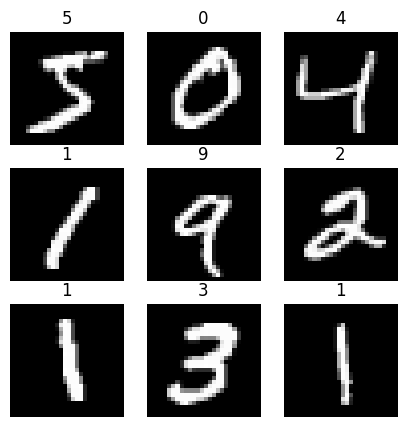

In [16]:
# 隨機檢視圖片
train_dataset[0]

figure = plt.figure(figsize=(5, 5))
cols, rows = 3, 3

for i in range(9):
    figure.add_subplot(cols, rows, i+1)
    plt.imshow(train_dataset[i][0].squeeze(), cmap="gray")
    plt.title(train_dataset[i][1])
    plt.axis("off")

In [17]:
# 檢視資料資訊
print(f"訓練資料數量: {len(train_dataset)}")
print(f"測試資料數量: {len(test_dataset)}\n")
print(f"圖片資料: {train_dataset[0][0].size()}")

訓練資料數量: 60000
測試資料數量: 10000

圖片資料: torch.Size([1, 28, 28])


# **Model_1 & functions**
1. Model_1 -> one Linear layer
2. Func : train, test, training loop ...

## 1.1 pip & import

In [18]:
!pip install torchinfo

In [19]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader
from torchinfo import summary

## 1.2 Model structure & build model

In [20]:
# Model structure & build model
device = "cuda" if torch.cuda.is_available() else "cpu"

class simpleNET(nn.Module):
    def __init__(self):
        super(simpleNET, self).__init__()

        self.layer_1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        probs = self.layer_1(x)
        return probs

model_1 = simpleNET().to(device)
summary(model_1)

Layer (type:depth-idx)                   Param #
simpleNET                                --
├─Sequential: 1-1                        --
│    └─Flatten: 2-1                      --
│    └─Linear: 2-2                       7,850
│    └─LogSoftmax: 2-3                   --
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0

## 1.3 Train function

In [21]:
# Train function
def train(model, dataloader, loss_fn, optimizer):
    model.train()

    total_loss, acc, count = 0, 0, 0

    for features, labels in dataloader:
        features = features.to(device)
        labels = labels.to(device)

        probs = model(features)
        loss = loss_fn(probs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss = total_loss + loss
        _, predicted = torch.max(probs, 1) # 找出probs 第一維度的最大值 -> 第一變數, 最大值是哪一個(較不重要, 所以使用_) / 第二變數, 最大值所在index (label)
        acc = acc + (predicted == labels).sum() # 僅計算, 預測label = True label
        count = count + len(labels)

        return total_loss.item()/count, acc.item()/count

In [24]:
# 測試 train function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_1.parameters(),
                            lr=0.01)

loss, acc = train(model = model_1,
                  dataloader = train_dataloader,
                  loss_fn = loss_fn,
                  optimizer = optimizer)

print(f"Train -> Loss: {loss} | Accuracy: {acc}")

Train -> Loss: 0.036656204611063004 | Accuracy: 0.015625


## 1.4 Test function

In [25]:
# Test function
def test(model, dataloader, loss_fn):
    model.eval()

    total_loss, acc, count = 0, 0, 0
    with torch.inference_mode():
        for features, labels in dataloader:
            features = features.to(device)
            labels = labels.to(device)

            probs = model(features)
            loss = loss_fn(probs, labels)
            # accumulate total_loss
            total_loss = total_loss + loss
            _, predicted = torch.max(probs, 1)
            # accumulate accuracy predict
            acc = acc + (predicted == labels).sum() # 僅計算, 預測label = True label
            count = count + len(labels)
    return total_loss.item()/count, acc.item()/count

In [26]:
# 測試 test function
loss_fn = nn.CrossEntropyLoss()

loss, acc = test(model = model_1,
                 dataloader = test_dataloader,
                 loss_fn = loss_fn)

print(f"Test -> Loss: {loss} | Accuracy: {acc}")

Test -> Loss: 0.03255674438476563 | Accuracy: 0.257


## 1.5 Training loop function and training loop
1. function
2. training loop
3. visualize

In [27]:
# Training loop function

def training_loop(model, train_dataloader, test_dataloader, loss_fn, optimizer, epochs):
    # 空字典, 用於儲存結果
    result_dict = {"train_loss":[], "train_acc":[], "test_loss":[], "test_acc":[]}

    for epoch in range(epochs):
        # train function
        train_loss, train_acc = train(model, train_dataloader, loss_fn, optimizer)

        # test function
        test_loss, test_acc = test(model, test_dataloader, loss_fn)

        # print process
        print(f"Epoch: {epoch}:")
        print(f"Train loss: {train_loss:.2f} | Train accuracy: {train_acc*100:.2f}%")
        print(f"Test loss: {test_loss:.2f} | Test accuracy: {test_acc*100:.2f}%")

        # 將結果存入字典
        result_dict["train_loss"].append(train_loss)
        result_dict["train_acc"].append(train_acc)
        result_dict["test_loss"].append(test_loss)
        result_dict["test_acc"].append(test_acc)

    return result_dict

In [28]:
# Training loop
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_1.parameters(),
                             lr = 0.01)

result = training_loop(model_1, train_dataloader, test_dataloader,
                       loss_fn = loss_fn,
                       optimizer = optimizer,
                       epochs=25)

Epoch: 0:
Train loss: 0.03 | Train accuracy: 29.69%
Test loss: 0.03 | Test accuracy: 53.10%
Epoch: 1:
Train loss: 0.03 | Train accuracy: 53.12%
Test loss: 0.02 | Test accuracy: 62.13%
Epoch: 2:
Train loss: 0.02 | Train accuracy: 71.88%
Test loss: 0.02 | Test accuracy: 54.85%
Epoch: 3:
Train loss: 0.02 | Train accuracy: 64.06%
Test loss: 0.02 | Test accuracy: 61.16%
Epoch: 4:
Train loss: 0.02 | Train accuracy: 70.31%
Test loss: 0.02 | Test accuracy: 68.46%
Epoch: 5:
Train loss: 0.02 | Train accuracy: 71.88%
Test loss: 0.02 | Test accuracy: 73.85%
Epoch: 6:
Train loss: 0.02 | Train accuracy: 71.88%
Test loss: 0.01 | Test accuracy: 76.34%
Epoch: 7:
Train loss: 0.02 | Train accuracy: 70.31%
Test loss: 0.01 | Test accuracy: 76.65%
Epoch: 8:
Train loss: 0.01 | Train accuracy: 82.81%
Test loss: 0.01 | Test accuracy: 76.35%
Epoch: 9:
Train loss: 0.01 | Train accuracy: 71.88%
Test loss: 0.01 | Test accuracy: 76.40%
Epoch: 10:
Train loss: 0.01 | Train accuracy: 79.69%
Test loss: 0.01 | Test accu

## 1.6 Visual model_1

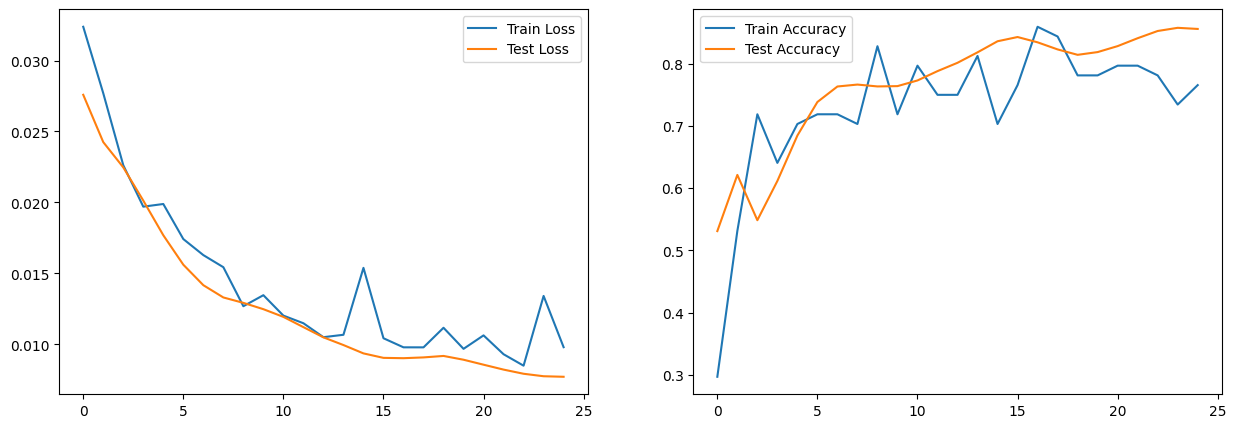

In [29]:
# Visualize
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(result["train_loss"], label="Train Loss")
plt.plot(result["test_loss"], label="Test Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(result["train_acc"], label="Train Accuracy")
plt.plot(result["test_acc"], label="Test Accuracy")
plt.legend()

# **Model_2**
1. Model_2 -> multi Linear layer & **activation**
2. 兩模型結果圖像化

## 2.1 Model structure & build model

In [30]:
# Model structure & build model
device = "cuda" if torch.cuda.is_available() else "cpu"

class CNN_2(nn.Module):
    def __init__(self):
        super(CNN_2, self).__init__()

        self.layer_1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        probs = self.layer_1(x)
        return probs

model_2 = CNN_2().to(device)
summary(model_2, input_size = (1, 28, 28), device = device)

Layer (type:depth-idx)                   Output Shape              Param #
CNN_2                                    [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Flatten: 2-1                      [1, 784]                  --
│    └─Linear: 2-2                       [1, 100]                  78,500
│    └─ReLU: 2-3                         [1, 100]                  --
│    └─Linear: 2-4                       [1, 10]                   1,010
│    └─LogSoftmax: 2-5                   [1, 10]                   --
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
Total mult-adds (M): 0.08
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.32
Estimated Total Size (MB): 0.32

## 2.2 Training loop

In [31]:
# Training loop
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_2.parameters(),
                             lr = 0.01)

result_2 = training_loop(model_2, train_dataloader, test_dataloader,
                         loss_fn = loss_fn,
                         optimizer = optimizer,
                         epochs=25)

Epoch: 0:
Train loss: 0.04 | Train accuracy: 6.25%
Test loss: 0.03 | Test accuracy: 38.59%
Epoch: 1:
Train loss: 0.03 | Train accuracy: 32.81%
Test loss: 0.03 | Test accuracy: 38.29%
Epoch: 2:
Train loss: 0.03 | Train accuracy: 35.94%
Test loss: 0.02 | Test accuracy: 54.65%
Epoch: 3:
Train loss: 0.03 | Train accuracy: 48.44%
Test loss: 0.02 | Test accuracy: 55.30%
Epoch: 4:
Train loss: 0.02 | Train accuracy: 56.25%
Test loss: 0.02 | Test accuracy: 65.26%
Epoch: 5:
Train loss: 0.01 | Train accuracy: 70.31%
Test loss: 0.01 | Test accuracy: 75.85%
Epoch: 6:
Train loss: 0.01 | Train accuracy: 82.81%
Test loss: 0.01 | Test accuracy: 76.83%
Epoch: 7:
Train loss: 0.02 | Train accuracy: 76.56%
Test loss: 0.01 | Test accuracy: 77.83%
Epoch: 8:
Train loss: 0.01 | Train accuracy: 85.94%
Test loss: 0.01 | Test accuracy: 76.34%
Epoch: 9:
Train loss: 0.01 | Train accuracy: 65.62%
Test loss: 0.01 | Test accuracy: 76.97%
Epoch: 10:
Train loss: 0.01 | Train accuracy: 81.25%
Test loss: 0.01 | Test accur

## 2.3 Visualize 2 models

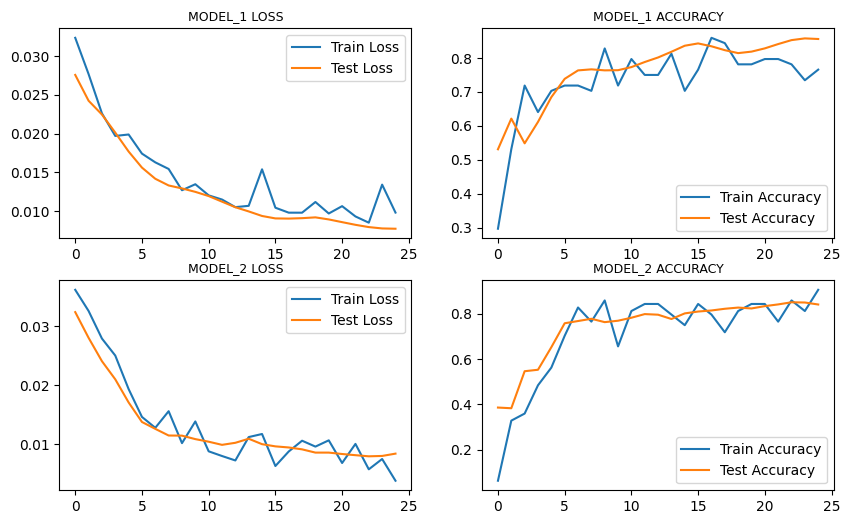

In [32]:
# Visualize
plt.figure(figsize=(10, 6))


plt.subplot(2, 2, 1)
plt.plot(result["train_loss"], label="Train Loss")
plt.plot(result["test_loss"], label="Test Loss")
plt.title("MODEL_1 LOSS", fontsize=9)
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(result["train_acc"], label="Train Accuracy")
plt.plot(result["test_acc"], label="Test Accuracy")
plt.title("MODEL_1 ACCURACY", fontsize=9)
plt.legend()


plt.subplot(2, 2, 3)
plt.plot(result_2["train_loss"], label="Train Loss")
plt.plot(result_2["test_loss"], label="Test Loss")
plt.title("MODEL_2 LOSS", fontsize=9)
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(result_2["train_acc"], label="Train Accuracy")
plt.plot(result_2["test_acc"], label="Test Accuracy")
plt.title("MODEL_2 ACCURACY", fontsize=9)
plt.legend()

# **Model_3**
1. Model_3 -> CNN
2. Conv2d -> Activation -> Flatten -> Output
3. 3模型視覺比較

## 3.1 Import

In [33]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torchinfo import summary

## 3.2 Model structure & build model

In [34]:
# Model structure and build model
device = "cuda" if torch.cuda.is_available() else "cpu"

class CNN_3(nn.Module):
    def __init__(self):
        super(CNN_3, self).__init__()

        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 10, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(6760, 10), # 先設置(1, 10) ->
            # RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x6760 and 1x10)
            # -> nn.Linear(6760, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        probs = self.block_1(x)
        return probs

model_3 = CNN_3().to(device)
summary(model_3, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNN_3                                    [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Conv2d: 2-1                       [1, 10, 26, 26]           100
│    └─ReLU: 2-2                         [1, 10, 26, 26]           --
│    └─Flatten: 2-3                      [1, 6760]                 --
│    └─Linear: 2-4                       [1, 10]                   67,610
│    └─LogSoftmax: 2-5                   [1, 10]                   --
Total params: 67,710
Trainable params: 67,710
Non-trainable params: 0
Total mult-adds (M): 0.14
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.27
Estimated Total Size (MB): 0.33

## 3.3 Training Loop

In [35]:
# training loop
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_3.parameters(),
                             lr = 0.01)

result_3 = training_loop(model_3, train_dataloader, test_dataloader,
                         loss_fn = loss_fn,
                         optimizer = optimizer,
                         epochs = 25)

Epoch: 0:
Train loss: 0.04 | Train accuracy: 15.62%
Test loss: 0.14 | Test accuracy: 19.31%
Epoch: 1:
Train loss: 0.15 | Train accuracy: 17.19%
Test loss: 0.13 | Test accuracy: 14.29%
Epoch: 2:
Train loss: 0.14 | Train accuracy: 12.50%
Test loss: 0.06 | Test accuracy: 22.73%
Epoch: 3:
Train loss: 0.06 | Train accuracy: 28.12%
Test loss: 0.07 | Test accuracy: 15.91%
Epoch: 4:
Train loss: 0.08 | Train accuracy: 21.88%
Test loss: 0.08 | Test accuracy: 15.61%
Epoch: 5:
Train loss: 0.09 | Train accuracy: 15.62%
Test loss: 0.08 | Test accuracy: 11.71%
Epoch: 6:
Train loss: 0.10 | Train accuracy: 1.56%
Test loss: 0.05 | Test accuracy: 41.90%
Epoch: 7:
Train loss: 0.06 | Train accuracy: 37.50%
Test loss: 0.05 | Test accuracy: 39.87%
Epoch: 8:
Train loss: 0.05 | Train accuracy: 42.19%
Test loss: 0.04 | Test accuracy: 41.33%
Epoch: 9:
Train loss: 0.06 | Train accuracy: 29.69%
Test loss: 0.03 | Test accuracy: 48.84%
Epoch: 10:
Train loss: 0.03 | Train accuracy: 48.44%
Test loss: 0.03 | Test accur

## 3.4 Visualize 3 models
-> conv2d best accuracy is better

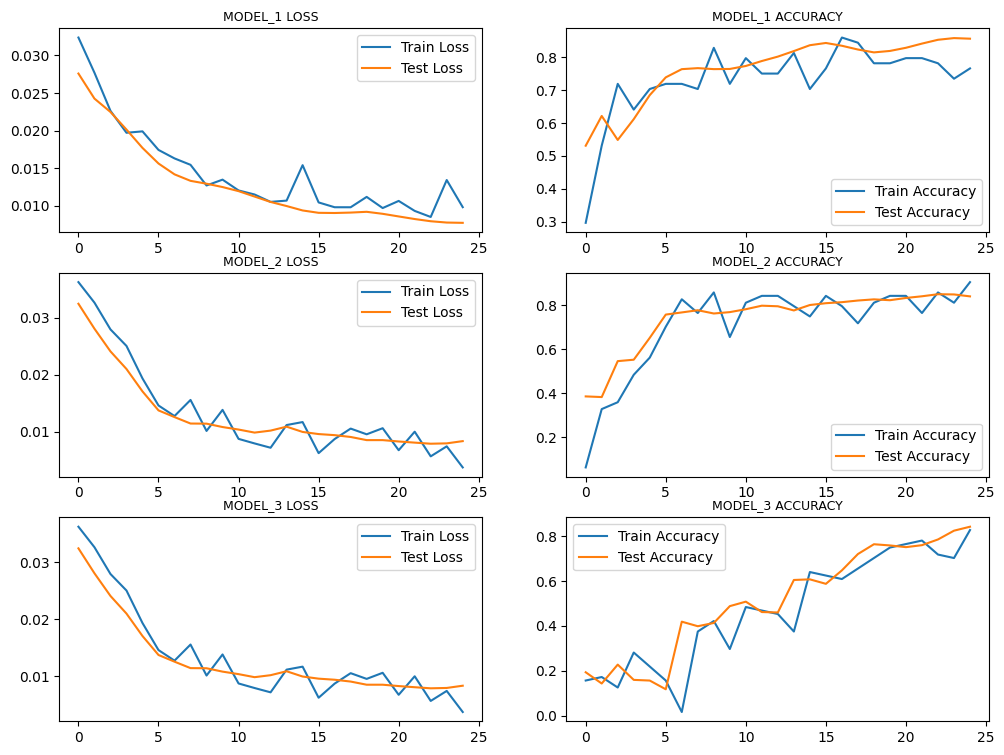

In [36]:
# Visualize
plt.figure(figsize=(12, 9))


plt.subplot(3, 2, 1)
plt.plot(result["train_loss"], label="Train Loss")
plt.plot(result["test_loss"], label="Test Loss")
plt.title("MODEL_1 LOSS", fontsize=9)
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(result["train_acc"], label="Train Accuracy")
plt.plot(result["test_acc"], label="Test Accuracy")
plt.title("MODEL_1 ACCURACY", fontsize=9)
plt.legend()


plt.subplot(3, 2, 3)
plt.plot(result_2["train_loss"], label="Train Loss")
plt.plot(result_2["test_loss"], label="Test Loss")
plt.title("MODEL_2 LOSS", fontsize=9)
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(result_2["train_acc"], label="Train Accuracy")
plt.plot(result_2["test_acc"], label="Test Accuracy")
plt.title("MODEL_2 ACCURACY", fontsize=9)
plt.legend()

plt.subplot(3, 2, 5)
plt.plot(result_2["train_loss"], label="Train Loss")
plt.plot(result_2["test_loss"], label="Test Loss")
plt.title("MODEL_3 LOSS", fontsize=9)
plt.legend()

plt.subplot(3, 2, 6)
plt.plot(result_3["train_acc"], label="Train Accuracy")
plt.plot(result_3["test_acc"], label="Test Accuracy")
plt.title("MODEL_3 ACCURACY", fontsize=9)
plt.legend()

# **Model_4**
1. CIFAR10
2. dataset, dataloader
3. Model_4 -> CNN multilayers


## 4.1 Import

In [37]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader

## 4.2 CIFAR10

In [38]:
# Transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

In [39]:
# Datasets
train_dataset = datasets.CIFAR10(
    root = "data",
    train = True,
    download = True,
    transform = transform)

test_dataset = datasets.CIFAR10(
    root = "data",
    train = False,
    download = True,
    transform = transform)

100%|██████████| 170498071/170498071 [00:12<00:00, 13119318.13it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [40]:
# DataLoader
train_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size = 150,
    shuffle = True)

test_dataloader = DataLoader(
    dataset = test_dataset,
    batch_size = 150,
    shuffle = False)

In [41]:
# label
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

torch.Size([150, 3, 32, 32])


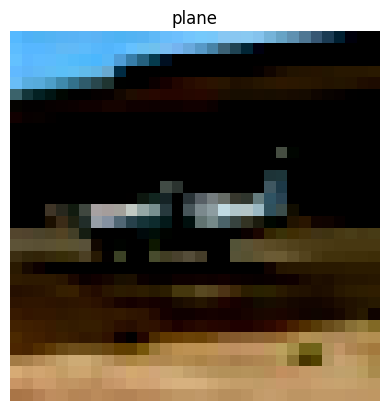

In [42]:
# 檢視資料集中圖像
iter_data = iter(train_dataloader)
image, label_index = next(iter_data)

print(image.size())
image = np.array(image[0].permute(1, 2, 0))
plt.imshow(image)

plt.title(classes[label_index[0]])
plt.gca().set_axis_off()

## 4.3 Model structure & build model


In [43]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [44]:
class CNN_4(nn.Module):
    def __init__(self):
        super(CNN_4, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        self.global_pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.pool = nn.MaxPool2d(2)
        self.flat = nn.Flatten()
        self.linear1 = nn.Linear(in_features=64, out_features=16)
        self.linear2 = nn.Linear(in_features=16, out_features=10)

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        # print(x.size())
        x = self.pool(nn.functional.relu(self.conv2(x)))
        # print(x.size())

        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        # print(x.size())

        x = self.flat(x)
        # print(x.size())
        x = nn.functional.relu(self.linear1(x))
        # print(x.size())
        x = self.linear2(x)
        # print(x.size())
        x = self.logsoftmax(x)
        # print(x.size())
        return x


model_4 = CNN_4().to(device)
summary(model_4, input_size=(1, 3, 32, 32))
# RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1920 and 120x64)

Layer (type:depth-idx)                   Output Shape              Param #
CNN_4                                    [1, 10]                   73,856
├─Conv2d: 1-1                            [1, 32, 32, 32]           896
├─MaxPool2d: 1-2                         [1, 32, 16, 16]           --
├─Conv2d: 1-3                            [1, 64, 16, 16]           18,496
├─MaxPool2d: 1-4                         [1, 64, 8, 8]             --
├─AdaptiveAvgPool2d: 1-5                 [1, 64, 1, 1]             --
├─Flatten: 1-6                           [1, 64]                   --
├─Linear: 1-7                            [1, 16]                   1,040
├─Linear: 1-8                            [1, 10]                   170
├─LogSoftmax: 1-9                        [1, 10]                   --
Total params: 94,458
Trainable params: 94,458
Non-trainable params: 0
Total mult-adds (M): 5.65
Input size (MB): 0.01
Forward/backward pass size (MB): 0.39
Params size (MB): 0.08
Estimated Total Size (MB): 0.49

## 4.4 Training loop

In [45]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_4.parameters(),
                             lr = 0.05)

result_4 = training_loop(model_4, train_dataloader, test_dataloader,
                         loss_fn = loss_fn,
                         optimizer = optimizer,
                         epochs = 25)

Epoch: 0:
Train loss: 0.02 | Train accuracy: 10.00%
Test loss: 0.03 | Test accuracy: 10.00%
Epoch: 1:
Train loss: 0.03 | Train accuracy: 8.00%
Test loss: 0.02 | Test accuracy: 11.16%
Epoch: 2:
Train loss: 0.02 | Train accuracy: 10.00%
Test loss: 0.02 | Test accuracy: 9.29%
Epoch: 3:
Train loss: 0.02 | Train accuracy: 6.00%
Test loss: 0.02 | Test accuracy: 10.34%
Epoch: 6:
Train loss: 0.02 | Train accuracy: 12.00%
Test loss: 0.02 | Test accuracy: 10.56%
Epoch: 7:
Train loss: 0.02 | Train accuracy: 13.33%
Test loss: 0.02 | Test accuracy: 12.73%
Epoch: 8:
Train loss: 0.02 | Train accuracy: 9.33%
Test loss: 0.02 | Test accuracy: 14.61%
Epoch: 9:
Train loss: 0.02 | Train accuracy: 16.00%
Test loss: 0.02 | Test accuracy: 14.07%
Epoch: 10:
Train loss: 0.02 | Train accuracy: 10.00%
Test loss: 0.02 | Test accuracy: 14.45%
Epoch: 11:
Train loss: 0.02 | Train accuracy: 16.00%
Test loss: 0.02 | Test accuracy: 14.62%
Epoch: 12:
Train loss: 0.02 | Train accuracy: 14.67%
Test loss: 0.02 | Test accura

## 4.5 Visualize

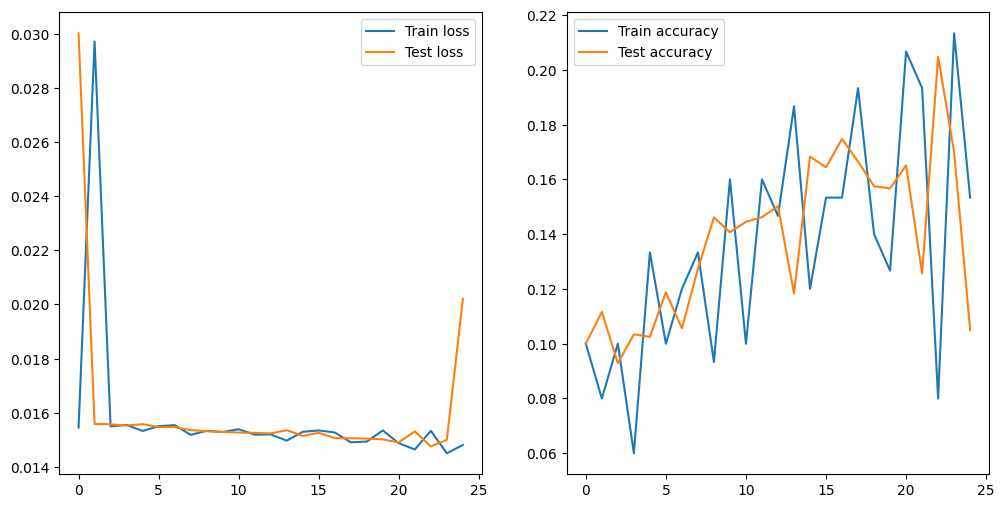

In [46]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(result_4["train_loss"], label="Train loss")
plt.plot(result_4["test_loss"], label="Test loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(result_4["train_acc"], label="Train accuracy")
plt.plot(result_4["test_acc"], label="Test accuracy")
plt.legend()

# Model_5
1. Cats & dogs datasets
2. 尚未使用: data augamentation, batch_normalize
3. 已經使用: AdaptiveAvgPool2d


## 5.1 Import

In [47]:
!pip install torchinfo

In [80]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchinfo import summary
from PIL import Image

## 5.2 Cats and dogs dataset
1. Download
2. Transform
3. Dataset: 所有資料轉成一份dataset -> 依照比例切割
4. Dataloader
5. Check image by dataloader

### Download and check

In [49]:
# Download

if not os.path.exists('data/kagglecatsanddogs_5340.zip'):
    !wget -P data -q https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

In [50]:
# Unzip file

if not os.path.exists('data/PetImages'):
    with zipfile.ZipFile('data/kagglecatsanddogs_5340.zip', 'r') as zip_ref:
        zip_ref.extractall('data')

In [51]:
# Check image

cat_folder_path = "/content/data/PetImages/Cat"
dog_folder_path = "/content/data/PetImages/Dog"

cat_file_list = os.listdir(cat_folder_path)
dog_file_list = os.listdir(dog_folder_path)

print(f"貓檔案數量:{len(cat_file_list)} | 狗檔案數量:{len(dog_file_list)}")

貓檔案數量:12501 | 狗檔案數量:12501


### Transform

In [52]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224), # 中心 -> 224, 224
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)) # 須與遷移學習對象使用相同方法Normalize
])

### Dataset

In [53]:
# # ImageFolder -> 僅從資料夾中讀取圖片放到dataset

# dataset = torchvision.datasets.ImageFolder("/content/data",
#                                            transform = transform)
# print(f"資料總數: {len(dataset)}")

In [81]:
# DatasetFolder

def check_image_file(file):
    try:
        with open(file, 'rb') as f:
            img = Image.open(f)
            img.verify()
        return True
    except Exception as e:
        print(f"Invalid image file: {file}")
        return False

dataset = torchvision.datasets.DatasetFolder(
    root = "/content/data/PetImages",
    loader = torchvision.datasets.folder.default_loader,
    transform = transform,
    is_valid_file = lambda file: file.endswith(".jpg") and check_image_file(file) # 僅讀取.jpg 檔案 & 檢查檔案是否可以正常讀取
)

Invalid image file: /content/data/PetImages/Cat/666.jpg
Invalid image file: /content/data/PetImages/Dog/11702.jpg


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:819: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [82]:
# 檢查labels
# 獲取所有的標籤
labels = dataset.targets

# 檢查獨一無二的標籤
unique_labels = set(labels)
num_classes = len(unique_labels)

print(f"總共的類別數量：{num_classes}")
print("各個類別的標籤：", unique_labels)

總共的類別數量：2
各個類別的標籤： {0, 1}


In [83]:
# Split
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])

print(f"訓練資料: {len(train_dataset)} | 測試資料: {len(test_dataset)}")

訓練資料: 19999 | 測試資料: 4999


### Dataloader

In [84]:
# Dataloader
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size = 64,
                                               shuffle = True)

test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size = 64,
                                              shuffle = False)

Cat
Cat
Cat
Cat


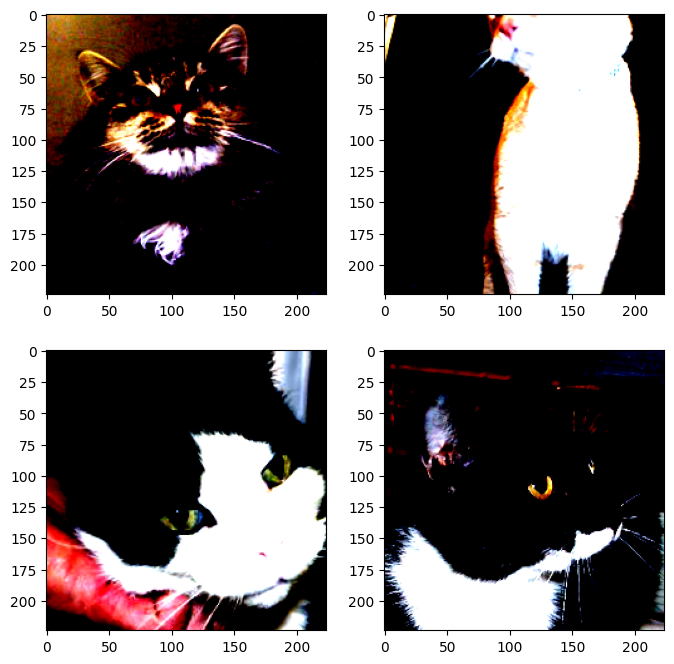

In [85]:
# Check image from dataloader

batch = next(iter(train_dataloader))

images = batch[0]
labels = batch[1]

plt.figure(figsize = (8, 8))

for i in range(4):
    plt.subplot(2, 2, i+1)
    image = images[i].permute(1, 2, 0)
    plt.imshow(image)

    label = labels[i].item()
    print("Cat" if label == 0 else "Dog")

## 5.3 Model structure and build model

In [115]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# 僅拿取 vgg16 特徵擷取的部分 / classifier -> 依照我方任務重新設定
# model_5 = torchvision.models.vgg16(pretrained=True).features
temp_model_5 = torchvision.models.vgg16(weights="DEFAULT").features

summary(temp_model_5, input_size=(1, 3, 244, 244))

In [117]:
# Classifier
model_5_classifier = nn.Sequential(
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Linear(512, 64),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(64, 8),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(8, 2),
    nn.Softmax(dim=1)
)

In [118]:
# 完整 model_5
model_5 = nn.Sequential(temp_model_5, model_5_classifier)
summary(model_5, input_size=(1, 3, 244, 244))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 2]                    --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 244, 244]         1,792
│    └─ReLU: 2-2                         [1, 64, 244, 244]         --
│    └─Conv2d: 2-3                       [1, 64, 244, 244]         36,928
│    └─ReLU: 2-4                         [1, 64, 244, 244]         --
│    └─MaxPool2d: 2-5                    [1, 64, 122, 122]         --
│    └─Conv2d: 2-6                       [1, 128, 122, 122]        73,856
│    └─ReLU: 2-7                         [1, 128, 122, 122]        --
│    └─Conv2d: 2-8                       [1, 128, 122, 122]        147,584
│    └─ReLU: 2-9                         [1, 128, 122, 122]        --
│    └─MaxPool2d: 2-10                   [1, 128, 61, 61]          --
│    └─Conv2d: 2-11                      [1, 256, 61, 61]          29

## 5.4 Training loop

In [119]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_5.parameters(),
                             lr = 0.001)

result_5 = training_loop(model_5, train_dataloader, test_dataloader,
                         loss_fn = loss_fn,
                         optimizer = optimizer,
                         epochs = 10)

Epoch: 0:
Train loss: 0.01 | Train accuracy: 46.88%
Test loss: 0.01 | Test accuracy: 50.19%
Epoch: 1:
Train loss: 0.01 | Train accuracy: 50.00%
Test loss: 0.01 | Test accuracy: 50.19%
Epoch: 2:
Train loss: 0.01 | Train accuracy: 42.19%
Test loss: 0.01 | Test accuracy: 50.19%
Epoch: 3:
Train loss: 0.01 | Train accuracy: 48.44%
Test loss: 0.01 | Test accuracy: 50.19%
Epoch: 4:
Train loss: 0.01 | Train accuracy: 54.69%
Test loss: 0.01 | Test accuracy: 50.19%
Epoch: 5:
Train loss: 0.01 | Train accuracy: 42.19%
Test loss: 0.01 | Test accuracy: 50.19%
Epoch: 6:
Train loss: 0.01 | Train accuracy: 39.06%
Test loss: 0.01 | Test accuracy: 50.19%
Epoch: 7:
Train loss: 0.01 | Train accuracy: 54.69%
Test loss: 0.01 | Test accuracy: 50.19%
Epoch: 8:
Train loss: 0.01 | Train accuracy: 48.44%
Test loss: 0.01 | Test accuracy: 50.19%
Epoch: 9:
Train loss: 0.01 | Train accuracy: 51.56%
Test loss: 0.01 | Test accuracy: 50.19%


## 5.5 Visualize

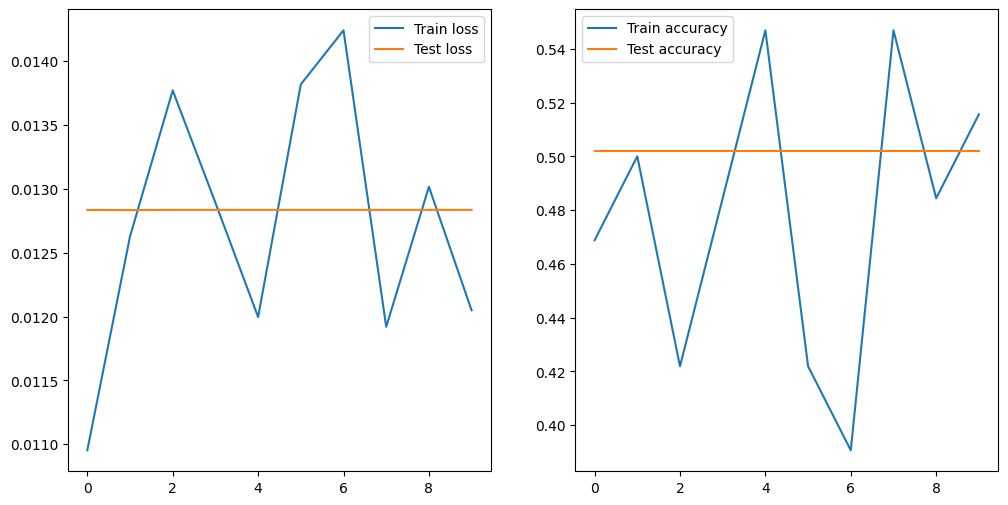

In [120]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(result_5["train_loss"], label="Train loss")
plt.plot(result_5["test_loss"], label="Test loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(result_5["train_acc"], label="Train accuracy")
plt.plot(result_5["test_acc"], label="Test accuracy")
plt.legend()

# 6. Model_6
1. Cats & dogs datasets
2. 尚未使用: data augamentation
3. 已經使用: batch_normalize, AdaptiveAvgPool2d
4. Visual

## 6.1 Model structure & build model

In [121]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
temp_model_6 = torchvision.models.resnet50()

summary(temp_model_6, input_size=(1, 3, 244, 244))

In [123]:
model_6_classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(1000, 128),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(128, 16),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(16, 2),
    nn.Softmax(dim=1)
)

In [124]:
# 完整 model_6
model_6 = nn.Sequential(temp_model_6, model_6_classifier)
summary(model_6, input_size=(1, 3, 244, 244))

Layer (type:depth-idx)                        Output Shape              Param #
Sequential                                    [1, 2]                    --
├─ResNet: 1-1                                 [1, 1000]                 --
│    └─Conv2d: 2-1                            [1, 64, 122, 122]         9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 122, 122]         128
│    └─ReLU: 2-3                              [1, 64, 122, 122]         --
│    └─MaxPool2d: 2-4                         [1, 64, 61, 61]           --
│    └─Sequential: 2-5                        [1, 256, 61, 61]          --
│    │    └─Bottleneck: 3-1                   [1, 256, 61, 61]          75,008
│    │    └─Bottleneck: 3-2                   [1, 256, 61, 61]          70,400
│    │    └─Bottleneck: 3-3                   [1, 256, 61, 61]          70,400
│    └─Sequential: 2-6                        [1, 512, 31, 31]          --
│    │    └─Bottleneck: 3-4                   [1, 512, 31, 31]          379,392

## 6.2 Training loop

In [125]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_6.parameters(),
                             lr = 0.001)

result_6 = training_loop(model_6, train_dataloader, test_dataloader,
                         loss_fn = loss_fn,
                         optimizer = optimizer,
                         epochs = 10)

Epoch: 0:
Train loss: 0.01 | Train accuracy: 45.31%
Test loss: 0.01 | Test accuracy: 50.31%
Epoch: 1:
Train loss: 0.01 | Train accuracy: 46.88%
Test loss: 0.01 | Test accuracy: 49.81%
Epoch: 2:
Train loss: 0.01 | Train accuracy: 54.69%
Test loss: 0.01 | Test accuracy: 49.61%
Epoch: 3:
Train loss: 0.01 | Train accuracy: 46.88%
Test loss: 0.01 | Test accuracy: 49.83%
Epoch: 4:
Train loss: 0.01 | Train accuracy: 56.25%
Test loss: 0.01 | Test accuracy: 49.85%
Epoch: 5:
Train loss: 0.01 | Train accuracy: 45.31%
Test loss: 0.01 | Test accuracy: 49.81%
Epoch: 6:
Train loss: 0.01 | Train accuracy: 51.56%
Test loss: 0.01 | Test accuracy: 49.81%
Epoch: 7:
Train loss: 0.01 | Train accuracy: 60.94%
Test loss: 0.01 | Test accuracy: 49.81%
Epoch: 8:
Train loss: 0.01 | Train accuracy: 53.12%
Test loss: 0.01 | Test accuracy: 49.81%
Epoch: 9:
Train loss: 0.01 | Train accuracy: 46.88%
Test loss: 0.01 | Test accuracy: 49.83%


## 6.3 Visual -> compare model_5 and model_6

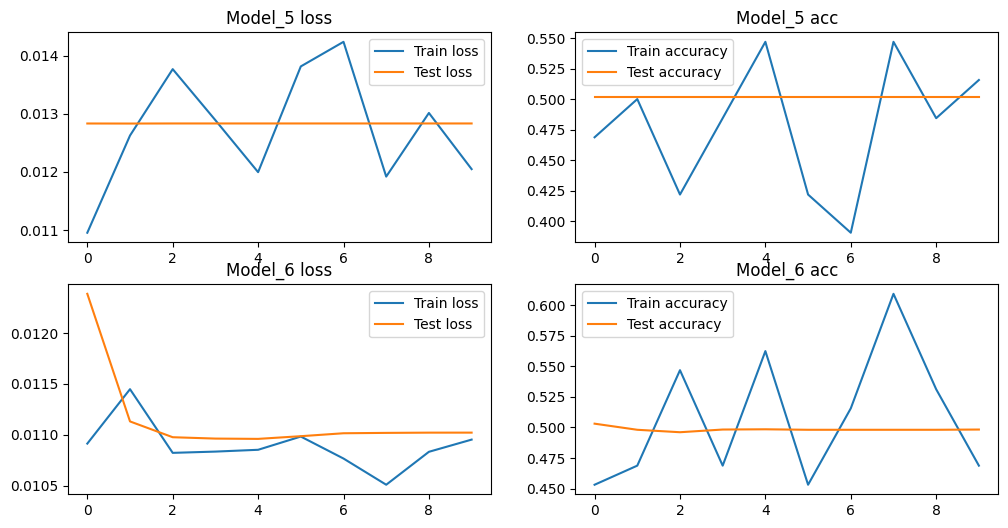

In [126]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(result_5["train_loss"], label="Train loss")
plt.plot(result_5["test_loss"], label="Test loss")
plt.title("Model_5 loss")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(result_5["train_acc"], label="Train accuracy")
plt.plot(result_5["test_acc"], label="Test accuracy")
plt.title("Model_5 acc")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(result_6["train_loss"], label="Train loss")
plt.plot(result_6["test_loss"], label="Test loss")
plt.title("Model_6 loss")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(result_6["train_acc"], label="Train accuracy")
plt.plot(result_6["test_acc"], label="Test accuracy")
plt.title("Model_6 acc")
plt.legend()